In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential ,load_model
from keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.preprocessing import image
from keras.preprocessing.image import load_img , ImageDataGenerator
from keras.utils import plot_model
from keras import callbacks
from sklearn.model_selection import train_test_split

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/Dog vs Cat Classification.zip"

In [32]:
Train_dir ='/content/Dog vs Cat Classification/train'
Test_dir ='/content/Dog vs Cat Classification/test1'

In [33]:
def load_dataset(directory):
  image_paths = []
  labels = []

  for filename in os.listdir(directory):
      image_path = os.path.join(directory, filename)
      image_paths.append(image_path)
      if filename.startswith("cat."):
        labels.append(0)
      else:
        labels.append(1)
  return image_paths, labels

In [34]:
train = pd.DataFrame()
test = pd.DataFrame()
train['images'] ,train['label'] =load_dataset(Train_dir)
test['images'] ,test['label'] =load_dataset(Test_dir)

In [35]:
train.head()

,images,label
0,/content/Dog vs Cat Classification/train/dog.7...,1
1,/content/Dog vs Cat Classification/train/dog.1...,1
2,/content/Dog vs Cat Classification/train/cat.3...,0
3,/content/Dog vs Cat Classification/train/cat.3...,0
4,/content/Dog vs Cat Classification/train/cat.1...,0


In [36]:
train['label'] =train['label'].astype(str)

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  25000 non-null  object
 1   label   25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


Data Visualisation

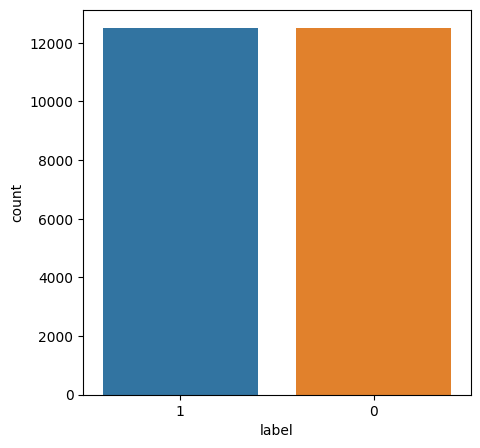

In [38]:
plt.figure(figsize=(5,5))
sns.countplot(x='label',data=train)
plt.show()

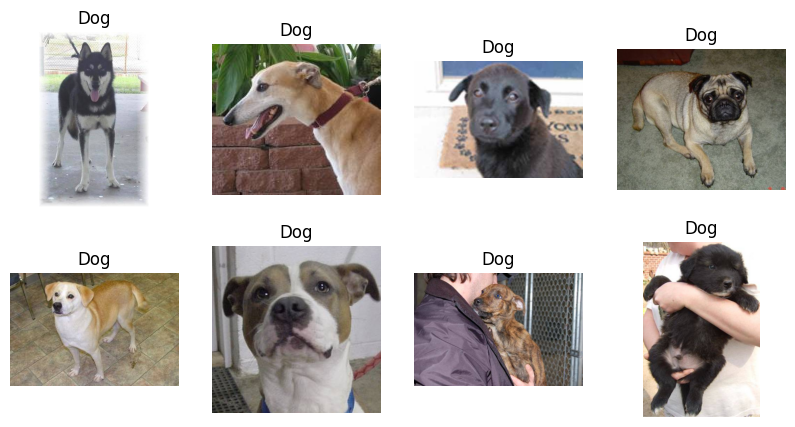

In [39]:
temp =train[train['label']=='1']['images']
j = random.randint(0,len(temp))
files = temp[j:j+8]

plt.figure(figsize=(10,5))
for index ,file in enumerate(files):
  plt.subplot(2,4,index+1)
  img =load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dog')
  plt.axis('off')

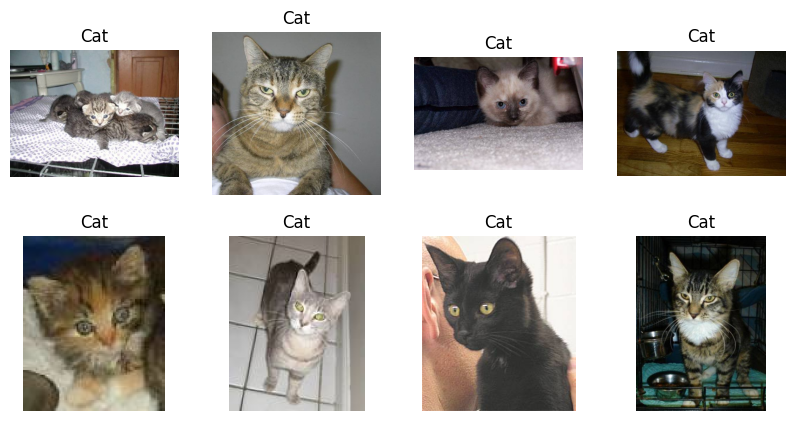

In [40]:
samp =train[train['label']=='0']['images']
j = random.randint(0,len(samp))
files = samp[j:j+8]

plt.figure(figsize=(10,5))
for index ,file in enumerate(files):
  plt.subplot(2,4,index+1)
  img =load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cat')
  plt.axis('off')

In [41]:
train_data ,val_data =train_test_split(train ,test_size =0.2,random_state=42)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

Creating Data Generator

In [42]:
train_datagenerator = ImageDataGenerator(
    rotation_range= 20,
    rescale =1./255,
    shear_range =0.2,
    zoom_range =0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
    )

validation_datagenerator =ImageDataGenerator(rescale =1./255)

train_generated = train_datagenerator.flow_from_dataframe(train_data,x_col='images',y_col ='label',target_size=(128,128),class_mode='binary',batch_size=128)

val_generated = validation_datagenerator.flow_from_dataframe(val_data,x_col='images',y_col ='label',target_size=(128,128),class_mode='binary',batch_size=128)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Model Architecture

In [43]:
from keras.src.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()

## CNN layer 1: Input block
model.add(Conv2D(32,(3,3),activation='relu',input_shape =(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## CNN layer 2 :
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## CNN layer 3 :
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## CNN layer 4 :
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

##Fully connected layer 1
model.add(Flatten())
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.2))

##Fully connected layer 1: output layer
model.add(Dense(1,activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 64)       

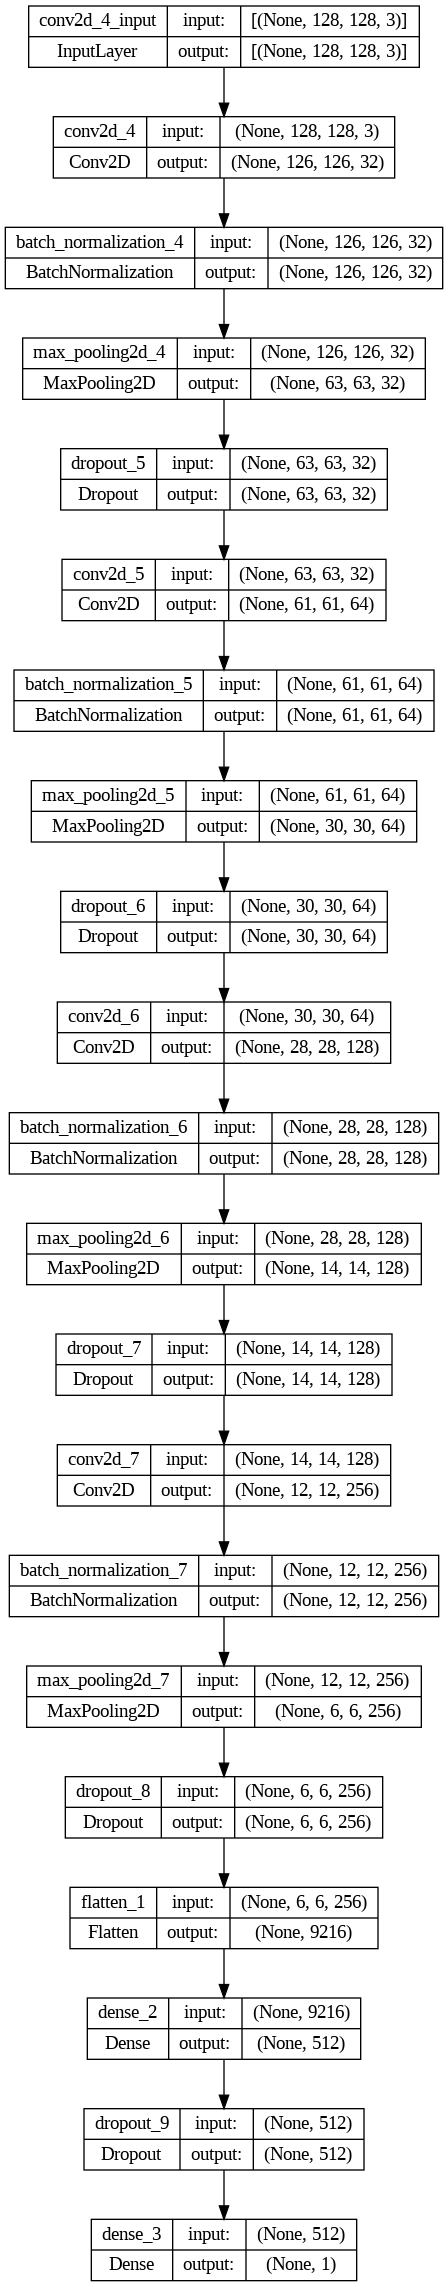

In [45]:
plot_model(model, show_shapes =True)

In [46]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode="min", patience=5,restore_best_weights=True)

In [47]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [50]:
training = model.fit(train_generated, validation_data= val_generated,epochs=20,callbacks=[earlystopping])

Epoch 1/20
157/157 [==============================] - 127s 808ms/step - loss: 0.5126 - accuracy: 0.7452 - val_loss: 0.8620 - val_accuracy: 0.5548
Epoch 2/20
157/157 [==============================] - 128s 813ms/step - loss: 0.4541 - accuracy: 0.7831 - val_loss: 0.6373 - val_accuracy: 0.6948
Epoch 3/20
157/157 [==============================] - 125s 798ms/step - loss: 0.4059 - accuracy: 0.8107 - val_loss: 0.5024 - val_accuracy: 0.7586
Epoch 4/20
157/157 [==============================] - 128s 815ms/step - loss: 0.3597 - accuracy: 0.8383 - val_loss: 0.3334 - val_accuracy: 0.8476
Epoch 5/20
157/157 [==============================] - 124s 788ms/step - loss: 0.3351 - accuracy: 0.8522 - val_loss: 0.3044 - val_accuracy: 0.8710
Epoch 6/20
157/157 [==============================] - 126s 801ms/step - loss: 0.3080 - accuracy: 0.8659 - val_loss: 0.4249 - val_accuracy: 0.8290
Epoch 7/20
157/157 [==============================] - 127s 808ms/step - loss: 0.2859 - accuracy: 0.8791 - val_loss: 0.6250 -

In [51]:
model.save('/content/drive/MyDrive/Saved models/DogCat_Classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Visualization of model performance

In [52]:
from keras.models import load_model
classifier =load_model('/content/drive/MyDrive/Saved models/DogCat_Classification.h5')

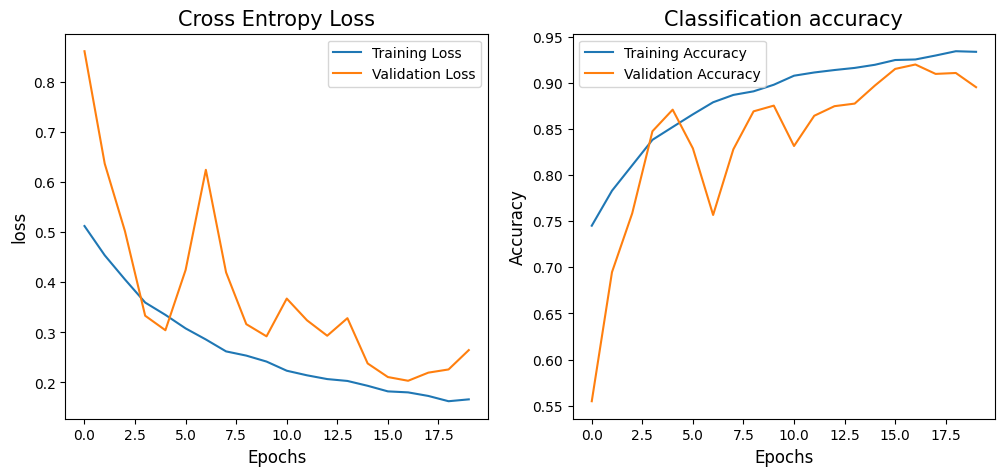

In [54]:
error =pd.DataFrame(training.history)
plt.figure(figsize=(12,5))
epochs = range(len(error['accuracy']))
plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.plot(error['loss'],label='Training Loss')
plt.plot(error['val_loss'],label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'],label='Training Accuracy')
plt.plot(error['val_accuracy'],label='Validation Accuracy')
plt.legend()

plt.show()

In [59]:
eval1 = classifier.evaluate(train_generated)
eval2 = classifier.evaluate(val_generated)

40/40 [==============================] - 9s 230ms/step - loss: 0.2647 - accuracy: 0.8954


In [60]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(eval1[1]*100,eval1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(eval2[1]*100,eval2[0]))

Training Accuracy  : 92.34%     Training loss  : 0.192057
Validation Accuracy: 89.54%     Validation loss: 0.264670


Image Prediction

1/1 [==============================] - 0s 18ms/step


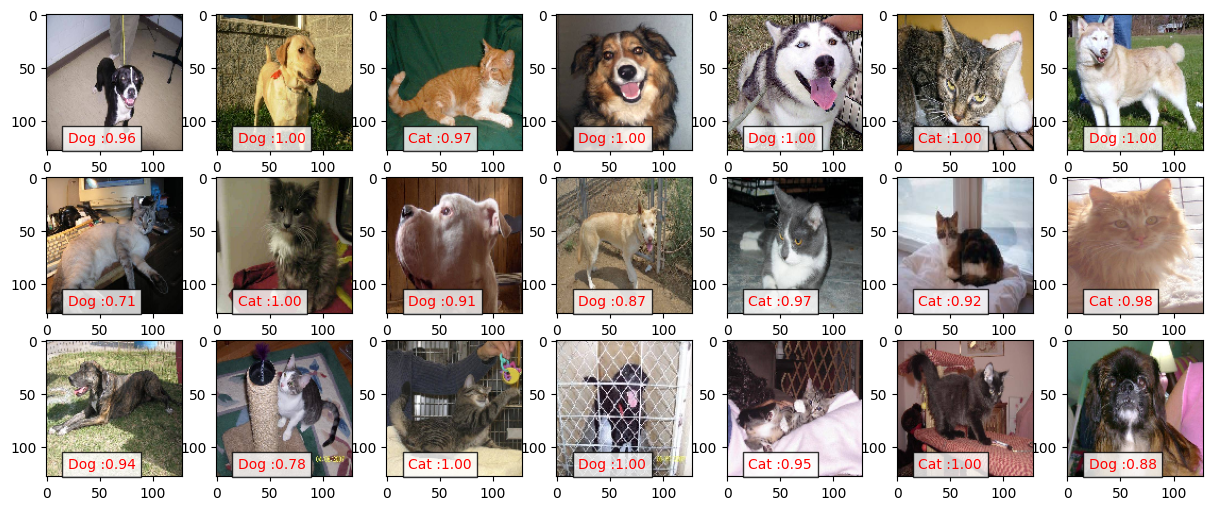

In [70]:
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img(test.images[np.random.choice(range(12500))], target_size=(128, 128))
    img = image.img_to_array(img1)
    img = img/255
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
        value ='Dog :%1.2f'%(prediction[0,0])
        plt.text(20, 120,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    else:
        value ='Cat :%1.2f'%(1.0-prediction[0,0])
        plt.text(20, 120,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1)